In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
import time
import matplotlib.pyplot as plt 

import os
os.chdir('../')

import data
import utils

In [2]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

In [3]:
def clean_target_predicted(target, predicted, remove_zeros = True):
    if isinstance(target, list):
        target = np.array(target)
    if isinstance(predicted, list):
        predicted = np.array(predicted)

    assert target.shape == predicted.shape, "Target and prediction don't have the same shape"
    assert isinstance(target, np.ndarray) and isinstance(predicted, np.ndarray), "Target and prediction should be numpy array"
    
    ## Removing zero observations in target data. 
    if remove_zeros:
        non_zeros = target != 0
        target = target[non_zeros]
        predicted = predicted[non_zeros]
    return target, predicted

def APE(target, predicted):
    return np.abs((target - predicted) / target)

def MAPE(target, predicted, axis = None):
    ape = APE(target, predicted)
    ape[ape == np.inf] = np.nan
    return np.nanmean(ape, axis = axis)

def MAAPE(target, predicted, axis = None):
    return np.mean(np.arctan(APE(target, predicted)), axis = axis)

def VAPE(target, predicted, axis = None):
    ape = APE(target, predicted)
    ape[ape == np.inf] = np.nan
    return np.nanvar(ape, axis = axis)

# def RMSE(target, predicted):
#     target, predicted = clean_target_predicted(target, predicted)
#     return np.sqrt(np.mean((target - predicted)**2))

In [4]:
def read_target(df, station, aggregation):
    # print("This is what is within the read_target:", station)
    data = df[station]

    if aggregation == 'day':
        forecast_window = 7
    elif aggregation == 'hour':
        forecast_window = 24
    elif aggregation == 'month':
        forecast_window = 12
    elif aggregation == '15mins':
        forecast_window = 8
    else:
        raise KeyError ('aggregation parameter is one of [day, hour, month, 15 mins]')

    shift_list = []
    col_list = []
    for i in range(forecast_window):
        shift_list.append(data.shift(-i))
        col_list.append('forecast_period_' + str(i + 1))
    target = pd.concat(shift_list, axis = 1)
    target.columns = col_list
    target = np.array(target.dropna())
    assert target.shape[1] == forecast_window
    target[target<10] = 0.0    ## Target less than 10 are put as zero. #Data cleaning
    return target[:-1,:]

In [5]:
def read_prediction(model, station, aggregation):
    path = os.path.join('output',aggregation, model, 'multioutput', station + '.json')
    try: 
        prediction = utils.read_json(path)
        prediction = np.array(prediction['prediction'])
        return prediction
    except FileNotFoundError:
        pass

In [6]:
def pre_post_split(df, date = '2020-03-15'):
    idx = dates[dates == date].index[0]
    pre = df[:idx,:]
    post = df[idx:,:]
    return pre, post

In [7]:
def analyis_process(directory, aggregation, metric, type_prediction = 'online'):
    
    if metric == 'mape':
        func = MAPE
    elif metric == 'maape':
        func = MAAPE
    elif metric == 'vape':
        func = VAPE
    else:
        raise ValueError ("{} is not a valid metric function". format(metric))

    results = {}
    models = os.listdir(os.path.join(directory, aggregation))
    models = ['cnn','dense','lstm'] # FIX ME. Hard coded neural network models 

    for model in models:
        # print(model)
        out_folder = os.path.join(directory, aggregation, model, type_prediction)
    
        try: 
            stations = os.listdir(out_folder)
            stations = list(set([x[:-5] for x in stations]))
            results[model] = {}
            row_list = []
            pre_post_list = []
            station_list = []
        except FileNotFoundError: 
            stations = None
            print ("something is worng")

        if stations is not None:

            for station in stations:
                if station in "models":
                    pass
                else:
                    target = read_target(test, station, aggregation)
                    predicted = read_prediction(model, station, aggregation)[:998,:] # FIX ME 

                    if model in ['arima', 'sarima']:
                        
                        predicted = predicted[31:-6]

                    # print(target[:5,:])
                    # print(predicted[:5,:])

                    assert target.shape == predicted.shape, "Target shape {}, is different from prediction shape {}".format(target.shape,predicted.shape)

                    pre_target, post_target = pre_post_split(target)
                    pre_predicted, post_predicted = pre_post_split(predicted)

                    row_metric = func(target, predicted, axis = 1)
                    pre_metric = func(pre_target, pre_predicted)
                    post_metric = func(post_target, post_predicted)
                    row_list.append(row_metric)
                    pre_post_list.append([pre_metric, post_metric])
                    station_list.append(station)
                
            #Store results
            results[model]['trend'] = row_list
            results[model]['pre_post'] = pre_post_list
            results[model]['stations'] = station_list

    sys_evolution_df = {}
    pre_post_df = {}

    for model in results.keys():
        value = np.vstack(results[model]['trend']).T
        value = pd.DataFrame(value, columns = results[model]['stations'], index = dates[:-7]) #FIX ME
        value['mean_metric'] = value.mean(axis = 1)
        sys_evolution_df[model] = value

        df = pd.DataFrame(data = results[model]['pre_post'], 
                        index = results[model]['stations'], columns = ['pre', 'post'])
        pre_post_df[model] = df

    return sys_evolution_df, pre_post_df

In [8]:
def plot_model_results(sys_evolution, pre_post):
    rows = 2 
    cols = len(sys_evolution)
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize = (20,8))

    counter = 0
    for model in sys_evolution.keys():
        sys_evolution[model]['mean_metric'].plot(ax = axs[0][counter])
        pre_post[model].plot.scatter(x = 'pre', y = 'post', ax = axs[1][counter])
        axs[1][counter].plot([0, 2], [0, 2], linewidth=2)
        axs[0][counter].set_title(model)
        counter +=1

In [9]:
def linear_regression(results):

    models_list = []
    models = list(results.keys())

    for model in models:
        # pre_name = 'pre_' + model
        # post_name = 'post_' + model
        # to_drop = ['(14004) museo del oro', '(10006) san victorino']
        xy = results[model].dropna()#.drop(index = to_drop)
        x = sm.add_constant(xy['pre'].rename('pre COVID-19'), prepend=False)
        y = xy['post']
        model = sm.OLS(y, x).fit()
        models_list.append(model)

    ols_results = summary_col(models_list,stars=True, info_dict = {"N":lambda x:(x.nobs)},
                              model_names = models, float_format='%.3f')

    return ols_results

In [10]:
directory = 'output'
data_directory = 'data'
aggregation = 'day'

settings = data.read_settings()
train, test = data.train_test_data(settings)
# test = test.iloc[31:]

# train, test = data.split_data(data_directory, aggregation = aggregation)
dates = pd.to_datetime(test.reset_index()[['year', 'month', 'day']])
dates = dates.reset_index(drop = True)

In [11]:
trend, pre_post = analyis_process(directory, aggregation, metric = 'maape', type_prediction='multioutput')

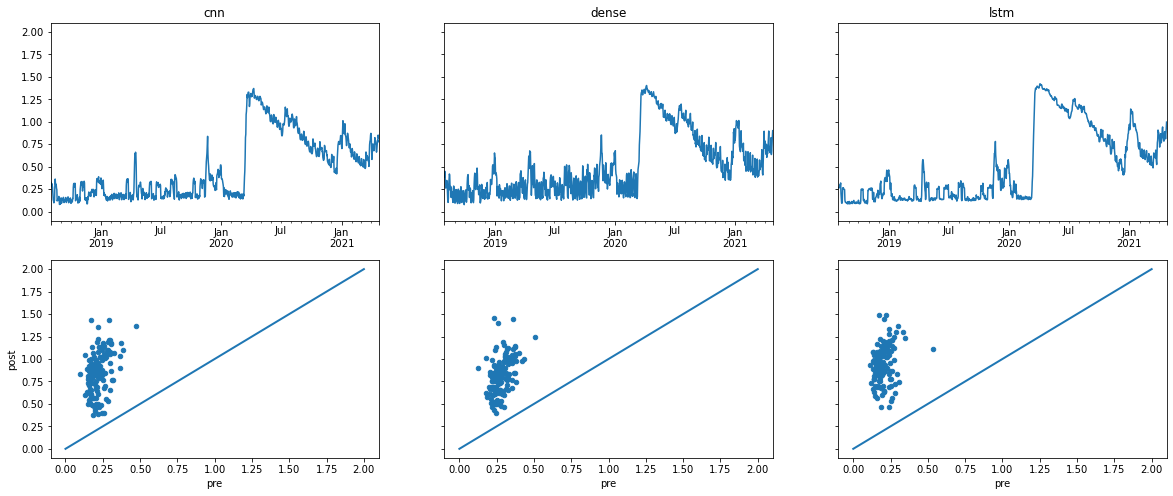

In [12]:
plot_model_results(trend, pre_post)

In [95]:
linear_regression(pre_post)

,cnn,dense,lstm
pre COVID-19,1.391***,1.391***,1.391***
,(0.311),(0.311),(0.311)
const,0.453***,0.453***,0.453***
,(0.068),(0.068),(0.068)
R-squared,0.121,0.121,0.121
R-squared Adj.,0.115,0.115,0.115
N,147.0000,147.0000,147.0000


In [33]:
linear_regression(pre_post)

,cnn,dense,lstm
pre COVID-19,1.716**,1.844***,1.554
,(0.817),(0.580),(0.951)
const,0.681***,0.654***,0.718***
,(0.140),(0.113),(0.167)
R-squared,0.102,0.202,0.064
R-squared Adj.,0.079,0.182,0.040
N,41.0000,42.0000,41.0000


## Pre-analysis :) 

In [25]:
def read_prediction(model, station, aggregation):
    path = os.path.join('output',aggregation, model, 'online', station + '.json')
    try: 
        prediction = utils.read_json(path)
        prediction = np.array(prediction['prediction'])
        return prediction
    except FileNotFoundError:
        pass

In [26]:
# Individual Models 
trend, pre_post = analyis_process(directory, aggregation, metric = 'maape', type_prediction='online')

AssertionError: Target shape (998, 7), is different from prediction shape (967, 7)

In [17]:
pre_post['cnn']['pre'].mean()

0.21290952127094542

In [20]:
trend, pre_post = analyis_process(directory, aggregation, metric = 'maape', type_prediction='online')

In [21]:
pre_post['cnn']['pre'].mean()

0.21290952127094542

In [157]:
example = pre_post['dense']

In [160]:
xy = example
x = xy['pre'].rename('pre COVID-19')
y = xy['post']
model = sm.OLS(y, x).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
==============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.915   
Dependent Variable:     post             AIC:                         29.8514 
Date:                   2022-02-09 17:15 BIC:                         32.8418 
No. Observations:       147              Log-Likelihood:              -13.926 
Df Model:               1                F-statistic:                 1574.   
Df Residuals:           146              Prob (F-statistic):          4.40e-80
R-squared (uncentered): 0.915            Scale:                       0.071248
----------------------------------------------------------------------------------
                  Coef.      Std.Err.        t        P>|t|      [0.025     0.975]
----------------------------------------------------------------------------------
pre COVID-19      4.1378       0.1043     39.6729     0.0000     3.9317     4.3439
------------------------------------------------------------------------------
Omnibus:                  49.193           Durbin-Watson:              2.253  
Prob(Omnibus):            0.000            Jarque-Bera (JB):           142.869
Skew:                     -1.298           Prob(JB):                   0.000  
Kurtosis:                 7.073            Condition No.:              1      
==============================================================================

"""

In [147]:
pre = example[['pre']]
pre['covid'] = 0
pre.columns = ['accuracy', 'covid']

post = example[['post']]
post['covid'] = 1
post.columns = ['accuracy', 'covid']

example_v1 = pd.concat((pre, post))

In [150]:
xy = example_v1
x = sm.add_constant(xy['covid'].rename('COVID'), prepend=True)
y = xy['accuracy']
model = sm.OLS(y, x).fit()

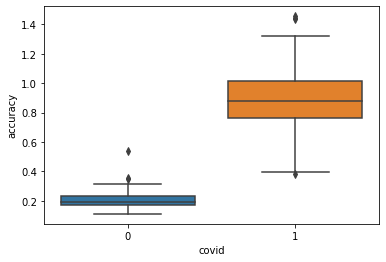

In [152]:
ax = sns.boxplot(x="covid", y="accuracy", data=example_v1)

In [151]:
model.summary2()                  

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.842    
Dependent Variable: accuracy         AIC:                -284.8574
Date:               2022-02-09 16:47 BIC:                -277.4902
No. Observations:   294              Log-Likelihood:     144.43   
Df Model:           1                F-statistic:        1568.    
Df Residuals:       292              Prob (F-statistic): 2.09e-119
R-squared:          0.843            Scale:              0.022069 
---------------------------------------------------------------------
          Coef.     Std.Err.       t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const     0.2042      0.0123    16.6689    0.0000    0.1801    0.2284
COVID     0.6861      0.0173    39.5919    0.0000    0.6520    0.7202
------------------------------------------------------------------
Omnibus:               25.012       Durbin-Watson:          2.246 
Prob(Omnibus):         0.000        Jarque-Bera (JB):       99.986
Skew:                  0.086        Prob(JB):               0.000 
Kurtosis:              5.852        Condition No.:          3     
==================================================================

"""

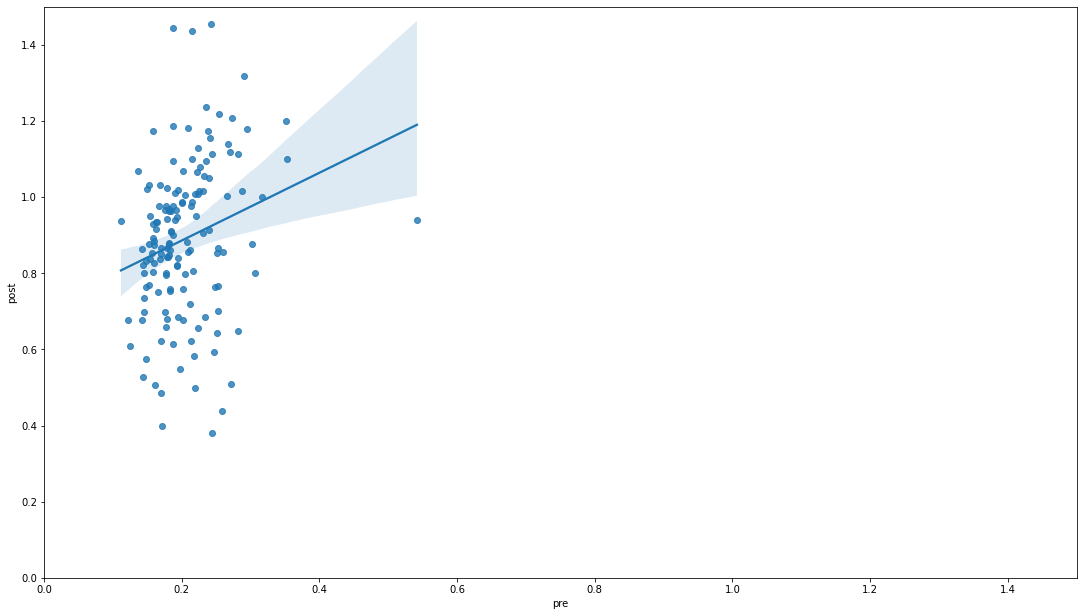

In [156]:
import seaborn as sns 
ax = sns.regplot(x="pre", y="post", data=example)
ax.set(ylim=(0, 1.5))
ax.set(xlim=(0, 1.5))
ax.figure.set_size_inches(18.5, 10.5)

There are some stations that have very little number of observations. For those stations, I should filter if there are less than 10 transactions per day. 

Also, in read_target, it seems that I drop np.nan. This shoul not happen. Check. 

In [75]:
df = pd.concat((train, test))
df = df[df.columns[~df.columns.isin(['dayofweek','weekday'])]]

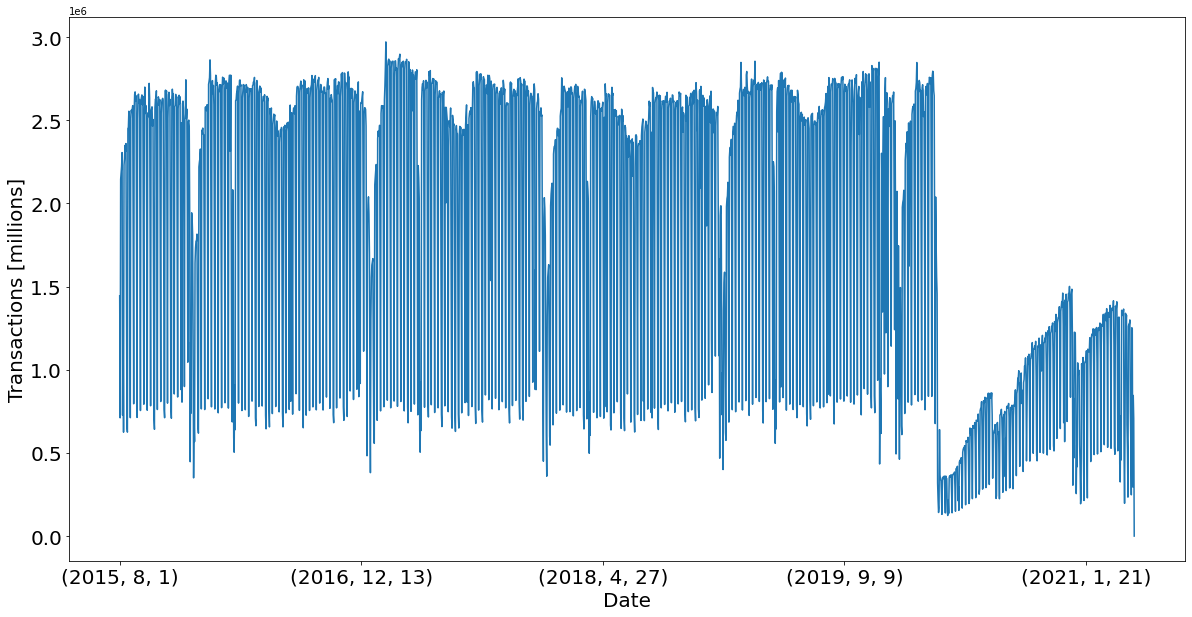

In [92]:

df.sum(axis = 1).plot(figsize = (20,10))
plt.ylabel('Transactions [millions]', fontsize = 20)
plt.xlabel('Date', fontsize = 20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20);

Index(['(02000) cabecera autopista norte', '(02001) centro comercial santa fe',
       '(02101) toberin', '(02102) calle 161', '(02103) mazuren',
       '(02104) calle 146', '(02105) calle 142', '(02200) alcala',
       '(02201) prado', '(02202) calle 127',
       ...
       '(12004) carrera 22', '(12007) zona industrial', '(14001) la sabana',
       '(14004) museo del oro', '(14005) las aguas', '(07010) bosa',
       '(40000) cable portal tunal', '(40001) juan pablo ii',
       '(40002) manitas', '(40003) mirador del paraiso'],
      dtype='object', length=151)

In [67]:
df.columns.isin(['dayofweek','weekday'])

array([ True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,